In [120]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

## Run 2 model
* MLP 
* LSTM

### ① MLP

In [121]:
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y
def load_imdb_dataset(path):
    imdb_path = os.path.join(path, 'aclImdb')

    # Load the dataset
    train_texts = []
    train_labels = []
    test_texts = []
    test_labels = []
    for dset in ['train', 'test']:
        for cat in ['pos', 'neg']:
            dset_path = os.path.join(imdb_path, dset, cat)
            for fname in sorted(os.listdir(dset_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(dset_path, fname)) as f:
                        if dset == 'train': train_texts.append(f.read())
                        else: test_texts.append(f.read())
                    label = 0 if cat == 'neg' else 1
                    if dset == 'train': train_labels.append(label)
                    else: test_labels.append(label)

    # Converting to np.array
    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    # Shuffle the dataset
    train_texts, train_labels = shuffle(train_texts, train_labels)
    test_texts, test_labels = shuffle(test_texts, test_labels)

    # Return the dataset
    return train_texts, train_labels, test_texts, test_labels

In [122]:
trX, trY, ttX, ttY = load_imdb_dataset('./data')
uniq_class_arr, counts = np.unique(trY, return_counts=True)
print ('Train samples shape :', trX.shape)
print ('Train labels shape  :', trY.shape)
print ('Test samples shape  :', ttX.shape)
print ('Test labels shape   :', ttY.shape)

Train samples shape : (25000,)
Train labels shape  : (25000,)
Test samples shape  : (25000,)
Test labels shape   : (25000,)


In [123]:
print(trX[0])
print(trY[0])

I found the memorable quotes searching for video clips; they forgot one of my favorites...<br /><br />Old Person 1: You know, I remember the first time they played that thing. <br /><br />Old Person 2: You remember pterodactyls. <br /><br />Old Person 1: And I can remember you fell for that, hook line and sinker. <br /><br />Old Person 2: Oh, I did not. <br /><br />Old Lady: You did so. You put a big bucket on your head and took off with them army boys to fight Martians. <br /><br />Old Person 2: Ain't you dead yet?
1


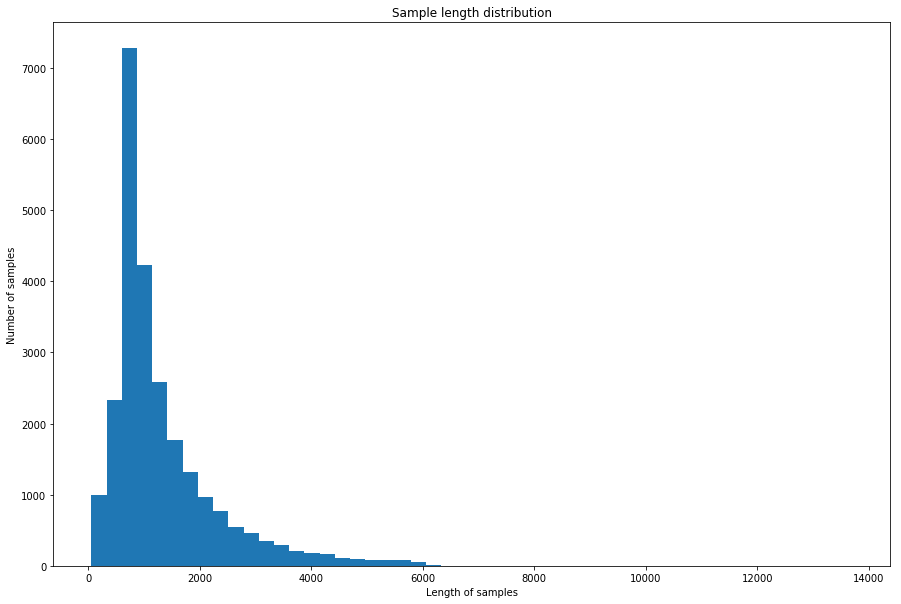

In [124]:
plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in trX], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [125]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}
vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(trX))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

In [126]:
print(len(all_counts))

74481


('the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she', 'when')
(336749, 164141, 145864, 135724, 107333, 101871, 96467, 93976, 76007, 73286, 48209, 46935, 44346, 44130, 44047, 42623, 40159, 34267, 34202, 30632, 30156, 29438, 29376, 27731, 26957, 26795, 23985, 23516, 22915, 22548, 21564, 21441, 20615, 20499, 20281, 18865, 18424, 18007, 17774, 17375, 17113, 16809, 16791, 16168, 15749, 15147, 14677, 14252, 14228, 14184)


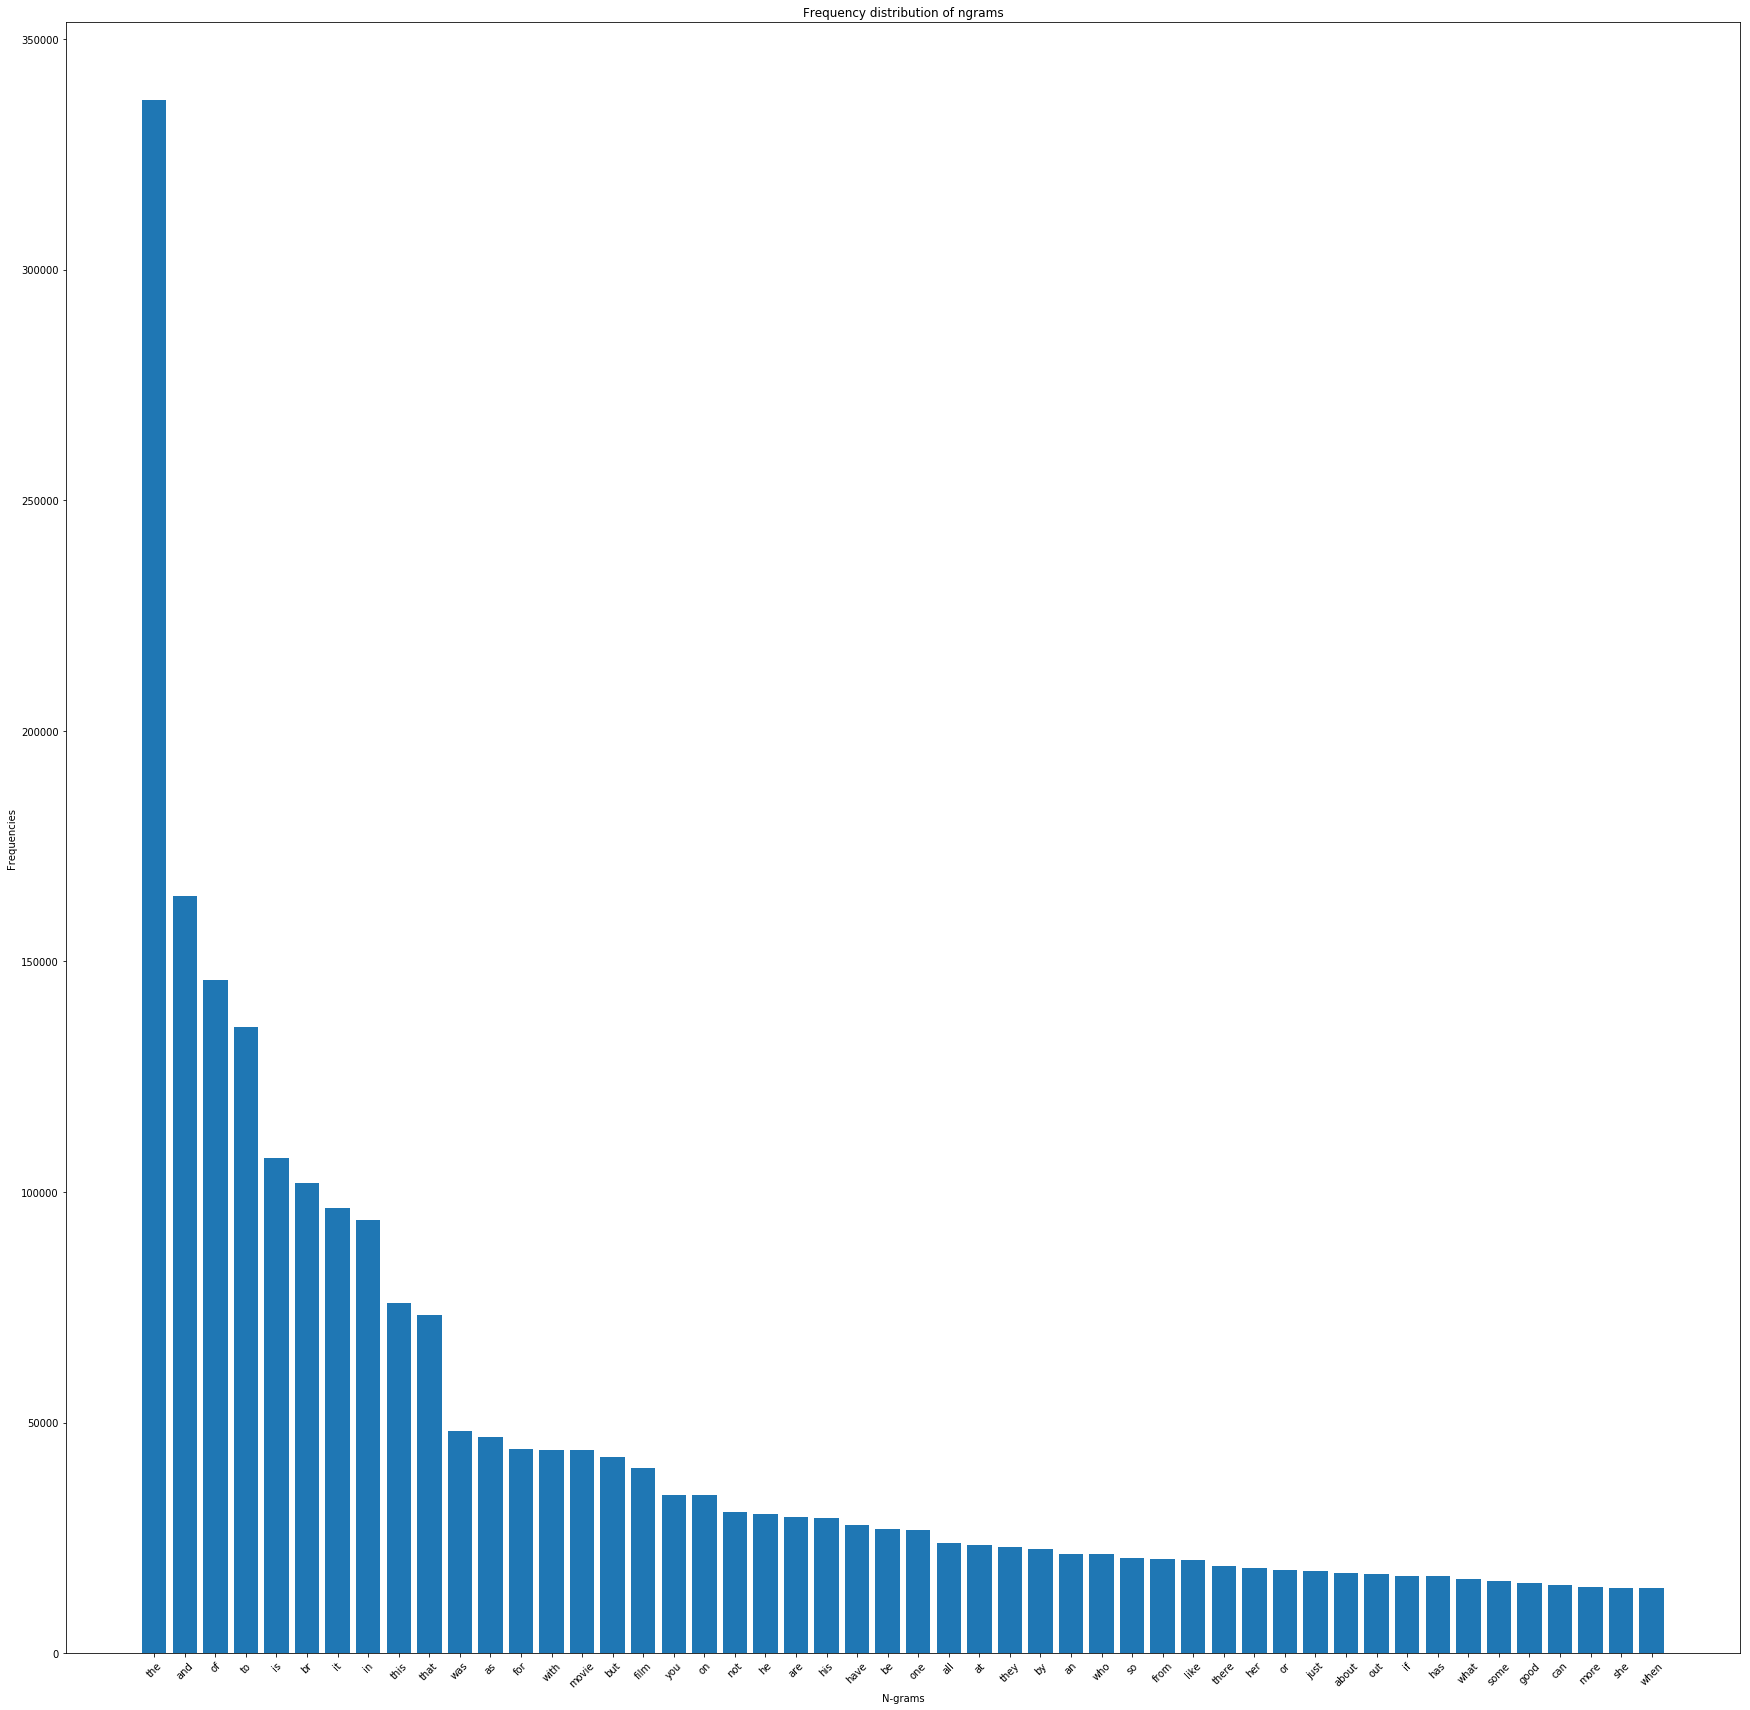

In [127]:
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

print(ngrams)
print(counts)
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [26]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_val = tfidf_vectorizer.transform(val_texts)
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [27]:
x_train, x_val = ngram_vectorize(trX, trY, ttX)

/Users/thangnguyen/pyenv_3.6_tensorflow/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1569: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [31]:
print(x_train.shape)
print(x_val.shape)

(25000, 20000)
(25000, 20000)


In [38]:
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu', bias_regularizer=tf.keras.regularizers.l2(0.01), use_bias=True))
#         model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [43]:
def train_ngram_model(data, learning_rate=1e-3, epochs=100, batch_size=128, layers=3, units=64, 
                      dropout_rate=0.2):
    
    num_classes = 2
    
    # Get the data
    trX, trY, ttX, ttY = data
    
    # Verify the validation labels
    '''
    unexpected_labels = [v for v in ttY if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the labels'
                         ' in the validation set are in the same range as '
                         'training labels.'.format(unexpected_labels=unexpected_labels))
    '''
    
    # Vectorize the data
    x_train, x_val = ngram_vectorize(trX, trY, ttX)
    
    # Create model instance
    model = mlp_model(layers, units=units, dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:], num_classes=num_classes)
    
    # Compile model with parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two epoch tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    
    # Train and validate model
    history = model.fit(x_train, trY, epochs=epochs, validation_data=(x_val, ttY),
                        verbose=2, batch_size=batch_size, callbacks=callbacks)
    
    # Print results
    history = history.history
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))
    
    # Save model
    model.save('IMDB_mlp_model_' + str(val_acc) + '_' + str(loss) + '.h5')
    return val_acc, val_loss

In [44]:
results = train_ngram_model((trX, trY, ttX, ttY))

print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

/Users/thangnguyen/pyenv_3.6_tensorflow/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1569: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 25000 samples, validate on 25000 samples
Epoch 1/100
 - 9s - loss: 0.3623 - acc: 0.8694 - val_loss: 0.2359 - val_acc: 0.9057
Epoch 2/100
 - 9s - loss: 0.1446 - acc: 0.9459 - val_loss: 0.2563 - val_acc: 0.8970
Epoch 3/100
 - 9s - loss: 0.0932 - acc: 0.9670 - val_loss: 0.2804 - val_acc: 0.8951
Validation accuracy: 0.895120000038147, loss: 0.28036271847724914
With lr=1e-3 | val_acc=0.895120000038147 | val_loss=0.28036271847724914


### ② LSTM

In [114]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [115]:
trX, trY, ttX, ttY = load_imdb_dataset('./data')

In [116]:
print(type(trX))
table = str.maketrans('', '', string.punctuation)
def clean_text(text):
    text=text.lower()
    text = re.split(r'\W+', text)
    text = [w.translate(table) for w in text]
    text = [w for w in text if not w in stop_words]
    text = ' '.join(text)
    return text

print(trX[0])
print('clean text')
print(clean_text(trX[0]))

<class 'numpy.ndarray'>
Twisted Desire (1996) was a TV movie starring Melissa Joan Hart. Melissa's character, Jennifer Stanton, a seventeen-year-old seduces her current boyfriend Nick Ryan into murdering her two parents. The movie is based on the 1990 murders of the parents of 14 year old Jessica Wiseman. Jessica had her 17 year old boyfriend Douglas Christopher Thomas shoot and kill her parents! Thomas was executed in 2000! Jessica was released from prison when she turned 21 years old. Evidence now suggests that it was Jessica who fired the fatal shot that killed her mother. Jessica is known to now be residing somewhere in the state of Virginia.
clean text
twisted desire 1996 tv movie starring melissa joan hart melissa character jennifer stanton seventeen year old seduces current boyfriend nick ryan murdering two parents movie based 1990 murders parents 14 year old jessica wiseman jessica 17 year old boyfriend douglas christopher thomas shoot kill parents thomas executed 2000 jessica 

In [117]:
for i in range(3):
    print(trX[i])
    print(' ')
train_x = [clean_text(x) for x in trX]
test_x = [clean_text(x) for x in ttX]
train_y = trY
test_y = ttY
for i in range(3):
    print(train_x[i])
    print(' ')

Twisted Desire (1996) was a TV movie starring Melissa Joan Hart. Melissa's character, Jennifer Stanton, a seventeen-year-old seduces her current boyfriend Nick Ryan into murdering her two parents. The movie is based on the 1990 murders of the parents of 14 year old Jessica Wiseman. Jessica had her 17 year old boyfriend Douglas Christopher Thomas shoot and kill her parents! Thomas was executed in 2000! Jessica was released from prison when she turned 21 years old. Evidence now suggests that it was Jessica who fired the fatal shot that killed her mother. Jessica is known to now be residing somewhere in the state of Virginia.
 
Elfriede Jelinek, not quite a household name yet, is a winner of the Nobel prize for literature. Her novel spawned a film that won second prize at Cannes and top prizes for the male and female leads. Am I a dinosaur in matters of aesthetic appreciation or has art become so debased that anything goes?<br /><br />'Gobble, gobble' is the favoured orthographic represen

In [118]:
import keras
max_features = 6000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_x)

In [119]:
list_tokenized_train = tokenizer.texts_to_sequences(train_x)
train_x_token = keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=256)

list_tokenized_test = tokenizer.texts_to_sequences(test_x)
test_x_token = keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=256)

In [98]:
from keras.layers import Embedding, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM
from keras.models import Model, Sequential

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
model.fit(train_x_token, train_y, batch_size=256, epochs=10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.5470 - acc: 0.7580 - val_loss: 0.3270 - val_acc: 0.8698
Epoch 2/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.2560 - acc: 0.9008 - val_loss: 0.2850 - val_acc: 0.8822
Epoch 3/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1816 - acc: 0.9351 - val_loss: 0.2977 - val_acc: 0.8792
Epoch 4/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1426 - acc: 0.9510 - val_loss: 0.3335 - val_acc: 0.8760
Epoch 5/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.1136 - acc: 0.9621 - val_loss: 0.3785 - val_acc: 0.8732
Epoch 6/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.0863 - acc: 0.9728 - val_loss: 0.4672 - val_acc: 0.8600
Epoch 7/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.0638 - acc: 0.9816 - val_loss: 0.5285 - val_acc:

In [110]:
X = np.concatenate([train_x_token, test_x_token])
y = np.concatenate([train_y, test_y])
print(X.shape)

(50000, 256)


In [107]:
print(list_tokenized_train[0])
print(train_x_token[0])

[4, 140, 25, 43, 32, 111, 5081, 445, 551, 61, 566, 39, 186, 8, 190, 14, 5081, 330, 17, 959, 344, 806, 3, 37, 6, 1773, 1756, 1491, 3816, 67, 245, 2, 433, 481, 806, 4697, 5305, 4022, 1602, 673, 206, 88, 132, 40, 73, 2, 752, 4, 775, 328, 1271, 4]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 

In [111]:
model.fit(X, y, batch_size=256, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.2197 - acc: 0.9225 - val_loss: 0.2978 - val_acc: 0.8797
Epoch 2/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.1427 - acc: 0.9522 - val_loss: 0.3240 - val_acc: 0.8802
Epoch 3/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.1070 - acc: 0.9670 - val_loss: 0.3540 - val_acc: 0.8786
Epoch 4/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.0788 - acc: 0.9766 - val_loss: 0.3852 - val_acc: 0.8779
Epoch 5/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.0588 - acc: 0.9836 - val_loss: 0.4660 - val_acc: 0.8735
Epoch 6/10
40000/40000 [==============================] - 116s 3ms/step - loss: 0.0442 - acc: 0.9883 - val_loss: 0.5021 - val_acc: 0.8736
Epoch 7/10
40000/40000 [==============================] - 117s 3ms/step - loss: 0.0347 - acc: 0.9906 - val_loss: 0.5465 - 